In [13]:
import os
import sys
import pandas as pd
import networkx as nx
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn import mixture
from sklearn.model_selection import train_test_split
from pycausal.pycausal import pycausal

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from aitia_explorer.app import App

# stop the warning clutter
import warnings
warnings.filterwarnings('ignore')

In [2]:
pc = pycausal()
pc.start_vm()

In [3]:
aitia = App()

In [6]:
lucas_df = aitia.data.lucas2_data()
lucas_df

,Smoking,Yellow_Fingers,Anxiety,Peer_Pressure,Genetics,Attention_Disorder,Born_an_Even_Day,Car_Accident,Fatigue,Allergy,Coughing,Lung_cancer
0,0,0,1,0,0,1,0,1,0,1,0,0
1,0,1,0,0,0,0,1,0,1,0,1,1
2,1,1,1,0,1,1,1,1,1,1,1,1
3,0,0,0,1,0,0,1,0,0,0,0,0
4,1,1,1,0,0,1,1,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0,0,1,0,0,0,0,1,1,0,1,1
1996,1,1,1,0,0,0,0,0,1,0,1,1
1997,1,1,0,1,0,0,1,0,1,0,0,1
1998,1,1,1,0,1,1,0,1,1,0,1,1


In [8]:
analysis_results, summary = aitia.run_analysis(lucas_df, 
                                               target_graph_str=None,
                                               algorithm_list=[
                                                    aitia.algo_runner.PC,
                                                    aitia.algo_runner.FCI,
                                               ],
                                               pc=pc)
summary

,Algorithm,Isomorphic to Target?,AURC,SHD
0,PC,NA,0,0
1,FCI,NA,0,0


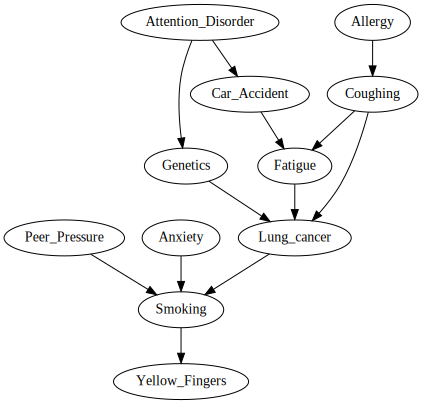

In [14]:
analysis_results[0]['causal_graph'].draw()

In [16]:
X = lucas_df
from sklearn import mixture

In [12]:
def SelBest(arr:list, X:int)->list:
    '''
    returns the set of X configurations with shorter distance
    '''
    dx=np.argsort(arr)[:X]
    return arr[dx]

In [17]:
# see https://towardsdatascience.com/gaussian-mixture-model-clusterization-how-to-select-the-number-of-components-clusters-553bef45f6e4
n_clusters=np.arange(2, 10)
bics=[]
bics_err=[]
iterations=20
for n in n_clusters:
    tmp_bic=[]
    for _ in range(iterations):
        gmm=mixture.GaussianMixture(n, n_init=2).fit(X) 
        tmp_bic.append(gmm.bic(X))
    val=np.mean(SelBest(np.array(tmp_bic), int(iterations/5)))
    err=np.std(tmp_bic)
    bics.append(val)
    bics_err.append(err)

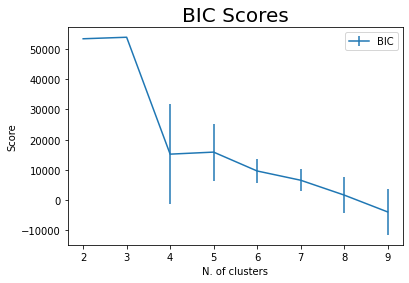

In [40]:
plt.errorbar(n_clusters,bics, yerr=bics_err, label='BIC')
plt.title("BIC Scores", fontsize=20)
plt.xticks(n_clusters)
plt.xlabel("N. of clusters")
plt.ylabel("Score")
plt.legend()

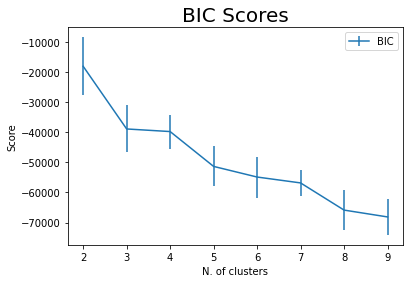

In [18]:
plt.errorbar(n_clusters,bics, yerr=bics_err, label='BIC')
plt.title("BIC Scores", fontsize=20)
plt.xticks(n_clusters)
plt.xlabel("N. of clusters")
plt.ylabel("Score")
plt.legend()

In [19]:
n_clusters=np.arange(2, 10)
sils=[]
sils_err=[]
iterations=20
for n in n_clusters:
    tmp_sil=[]
    for _ in range(iterations):
        gmm=mixture.GaussianMixture(n, n_init=2).fit(X) 
        labels=gmm.predict(X)
        sil=metrics.silhouette_score(X, labels, metric='euclidean')
        tmp_sil.append(sil)
    val=np.mean(SelBest(np.array(tmp_sil), int(iterations/5)))
    err=np.std(tmp_sil)
    sils.append(val)
    sils_err.append(err)

Text(0, 0.5, 'Score')

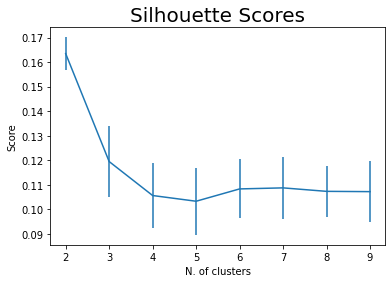

In [24]:
plt.errorbar(n_clusters, sils, yerr=sils_err)
plt.title("Silhouette Scores", fontsize=20)
plt.xticks(n_clusters)
plt.xlabel("N. of clusters")
plt.ylabel("Score")

In [21]:

#Courtesy of https://stackoverflow.com/questions/26079881/kl-divergence-of-two-gmms. Here the difference is that we take the squared root, so it's a proper metric

def gmm_js(gmm_p, gmm_q, n_samples=10**5):
    X = gmm_p.sample(n_samples)[0]
    log_p_X = gmm_p.score_samples(X)
    log_q_X = gmm_q.score_samples(X)
    log_mix_X = np.logaddexp(log_p_X, log_q_X)

    Y = gmm_q.sample(n_samples)[0]
    log_p_Y = gmm_p.score_samples(Y)
    log_q_Y = gmm_q.score_samples(Y)
    log_mix_Y = np.logaddexp(log_p_Y, log_q_Y)

    return np.sqrt((log_p_X.mean() - (log_mix_X.mean() - np.log(2))
            + log_q_Y.mean() - (log_mix_Y.mean() - np.log(2))) / 2)

In [22]:
n_clusters=np.arange(2, 10)
iterations=20
results=[]
res_sigs=[]
for n in n_clusters:
    dist=[]
    
    for iteration in range(iterations):
        train, test=train_test_split(X, test_size=0.5)
        
        gmm_train=mixture.GaussianMixture(n, n_init=2).fit(train) 
        gmm_test=mixture.GaussianMixture(n, n_init=2).fit(test) 
        dist.append(gmm_js(gmm_train, gmm_test))
    selec=SelBest(np.array(dist), int(iterations/5))
    result=np.mean(selec)
    res_sig=np.std(selec)
    results.append(result)
    res_sigs.append(res_sig)

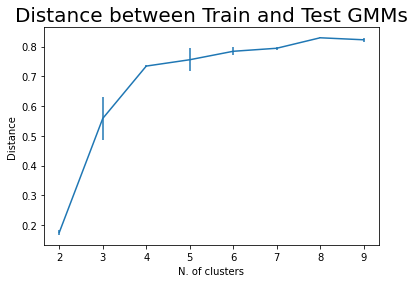

In [23]:

plt.errorbar(n_clusters, results, yerr=res_sigs)
plt.title("Distance between Train and Test GMMs", fontsize=20)
plt.xticks(n_clusters)
plt.xlabel("N. of clusters")
plt.ylabel("Distance")
plt.show()

In [45]:
X.shape

(2000, 12)

In [27]:
X = lucas_df
from sklearn import mixture
gmm = mixture.BayesianGaussianMixture(n_components=3).fit(X)
labels = gmm.predict(X)

In [28]:
data_new = gmm.sample(2000)
X_new = pd.DataFrame(data_new[0], columns=list(X))
X_new

,Smoking,Yellow_Fingers,Anxiety,Peer_Pressure,Genetics,Attention_Disorder,Born_an_Even_Day,Car_Accident,Fatigue,Allergy,Coughing,Lung_cancer
0,0.159977,-0.254214,0.428158,0.534405,-0.021681,-0.145149,-0.075570,1.034515,1.263748,0.405320,0.662528,0.727779
1,0.754899,0.223375,0.940135,-0.258634,0.001796,0.360891,1.260958,1.132472,0.940147,0.446656,1.126702,0.498351
2,0.220140,0.488347,0.443865,0.323908,0.009076,0.177081,0.425903,0.446214,0.765599,-0.178270,-0.210993,0.468899
3,0.260060,0.127383,0.488605,0.162717,-0.011828,-0.593117,0.523903,0.238084,-0.098469,0.520740,-0.226181,-0.202108
4,0.772982,1.205746,0.604787,-0.064496,0.001812,0.301133,0.345309,0.405266,0.447669,0.820908,0.593987,0.091350
...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.882442,0.939295,0.865710,1.588194,0.341772,0.436842,0.993425,0.551114,0.396559,-0.857691,0.160415,1.063569
1996,0.941344,0.886031,0.532221,1.116757,-0.123851,-0.055392,0.992501,0.569955,0.713758,0.905079,0.365788,0.955160
1997,0.965095,0.831787,1.429331,0.150571,0.226523,-0.230078,1.040119,0.931599,0.478686,0.382827,0.936198,0.971116
1998,1.023911,1.054984,0.940157,-1.127438,-0.769420,0.353700,1.010597,0.976711,1.332199,0.828718,1.389972,1.029224


In [30]:
analysis_results2, summary2 = aitia.run_analysis(X_new, 
                                               target_graph_str=None, 
                                               algorithm_list=[
                                                   aitia.algo_runner.PC,
                                                   aitia.algo_runner.FCI,
                                                   aitia.algo_runner.FGES_continuous,
                                                   aitia.algo_runner.GFCI_continuous,
                                                   aitia.algo_runner.RFCI_continuous,
                                               ],
                                               pc=pc)
summary2

,Algorithm,Isomorphic to Target?,AURC,SHD
0,PC,NA,0,0
1,FCI,NA,0,0
2,FGES-continuous,NA,0,0
3,GFCI-continuous,NA,0,0
4,RFCI-continuous,NA,0,0


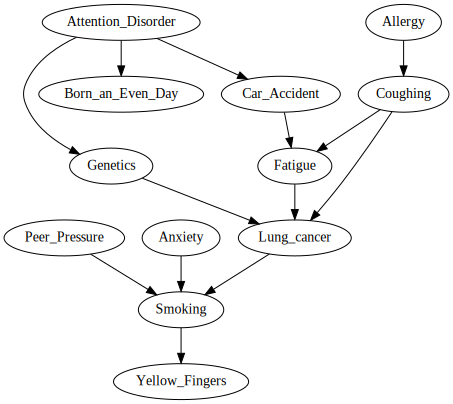

In [31]:
analysis_results2[3]['causal_graph'].draw()

In [93]:
summary # without clustering

,Algorithm,Isomorphic to Target?,AURC,SHD
0,PC,False,0.380102,18
1,FCI,False,0.380102,18
2,FGES-continuous,False,0.368197,19
3,GFCI-continuous,False,0.380102,18
4,RFCI-continuous,False,0.380102,18


In [94]:
summary2 # with clustering

,Algorithm,Isomorphic to Target?,AURC,SHD
0,PC,False,0.409864,16
1,FCI,False,0.409864,16
2,FGES-continuous,False,0.393838,17
3,GFCI-continuous,False,0.409864,16
4,RFCI-continuous,False,0.409864,16
